In [1]:
import sys
sys.path.append("../src")

In [2]:
import sn_graph as sn 
from skimage import io
import numpy as np
import skfmm
from skimage.filters import gaussian as gaussian_blur
from skimage.filters import threshold_local
import matplotlib.pyplot as plt


In [3]:
def blur_and_threshold(image: np.ndarray, blur: bool=False, sigma: float=1, block_size: int=50, offset: float=0):
    im=image.copy()

    if blur:
        im=gaussian_blur(im, sigma=sigma)

    local_thresh = threshold_local(im, block_size, offset=offset)
    binary_local = im > local_thresh

    im=binary_local.astype(float)
    return im


create_SN_graph took 3.725327 seconds

Graph Statistics:
Number of nodes: 1
Number of edges: 0



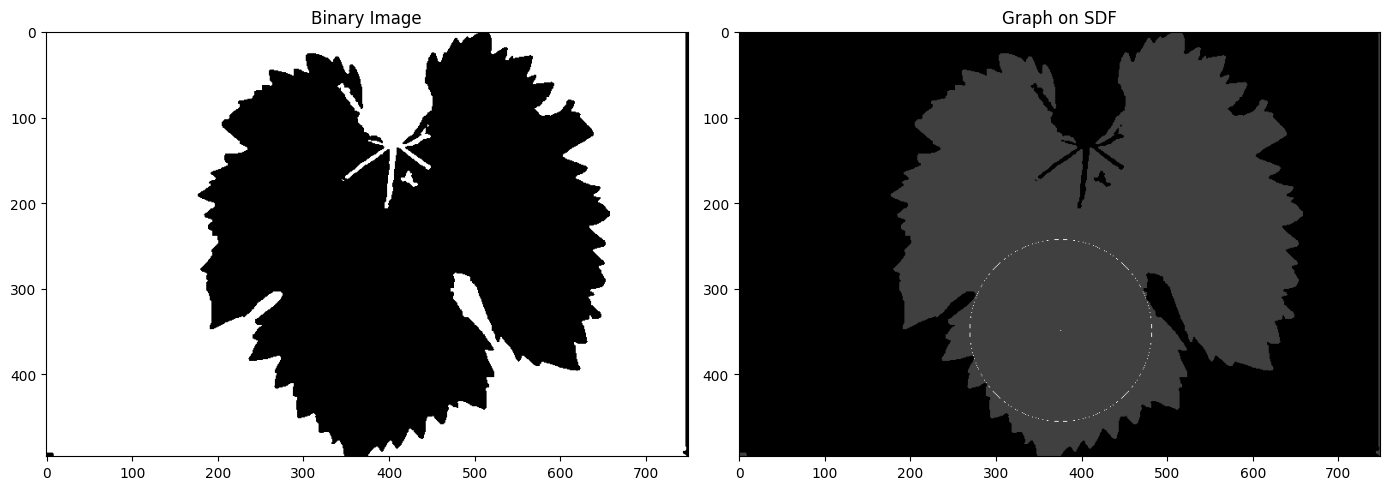

In [4]:

# Read and process image
full_im = io.imread('../tests/leaf.jpeg')
im = full_im[:,:,0]
processed_im = blur_and_threshold(im, blur=True, sigma=1, block_size=35, offset=0)

spheres_centres, edges = sn.create_SN_graph(image=processed_im, max_num_vertices=1, edge_threshold=0.95, 
                                          max_edge_length=200, minimal_sphere_radius=8)



sdf_array = skfmm.distance(processed_im, dx=1)
graph_im = sn.draw_graph_on_top_of_SDF(sdf_array, spheres_centres, edges)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))

# Plot binary image
ax1.imshow(processed_im, cmap='binary')
ax1.set_title('Binary Image')

# Plot SDF with graph
ax2.imshow(graph_im, cmap='gray')
ax2.set_title('Graph on SDF')

# Print graph statistics in text below
print(f"""
Graph Statistics:
Number of nodes: {len(spheres_centres)}
Number of edges: {len(edges)}
""")

# Adjust layout and display
plt.tight_layout()
plt.show()



## TODO: 
- make it not stall if defaults are set to 0 (find out why it stalls)
- it doesnt add some obvious edges, find out why, and make them add (the edge to tip spheres): could it be that it is because we remove soem stuff from sdf on the fly, so then the edges do not pass the criterion?
- makes overlap between spheres too big, is it a property of the distance or what? can it be changed?
- verify input image and put soem guardrails, e.g. for non binary. depends on what SDF fucntion accepts
- make output into some good format
- write tests for small functions
- better name functions and variables
- add more examples